##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

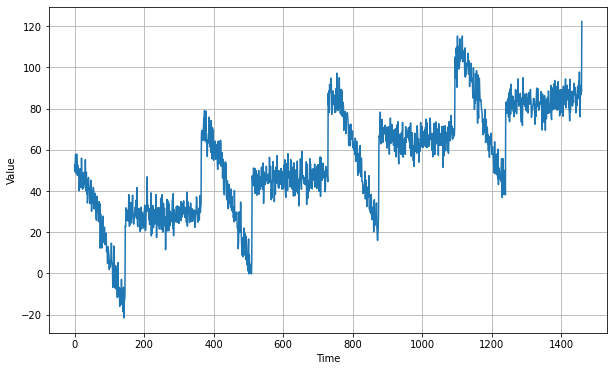

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 35s 74ms/step - loss: 87.8346 - mae: 88.3341 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 87.1197 - mae: 87.6191 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 85.9241 - mae: 86.4234 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 84.3720 - mae: 84.8713 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 82.4703 - mae: 82.9696 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 80.2434 - mae: 80.7427 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 77.7459 - mae: 78.2453 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 75.0957 - mae: 75.5952 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 18ms/step - loss: 72.4508 - mae: 72.9503 - lr: 2.

(1e-08, 0.0001, 0.0, 30.0)

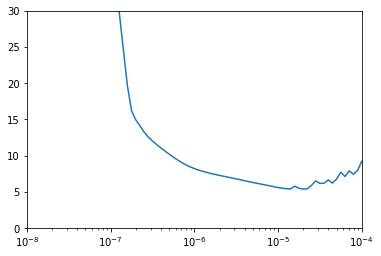

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#seq2seq -> train, validation dataset을 window size 크기의 배열로 나누고, 마지막 값을 따로 빼서 label로 만듦

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)
#Conv1D - Stateless LSTM RNN 2개 - Dense
#Conv1D -> RNN에 넣기 전에, 인풋 데이터를 정리하는 용도
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
8/8 [==============================] - 5s 204ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 39ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9232 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 42ms/step - loss: 17.3629 - mae: 17.8584 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 1s 44ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 1s 46ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 1s 45ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0114 - val_mae: 16.5063
Epoch 7/500
8/8 [==============================] - 1s 46ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5160 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 1s 45ms/step - 

In [8]:
model = keras.models.load_model("my_checkpoint.h5")

In [9]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

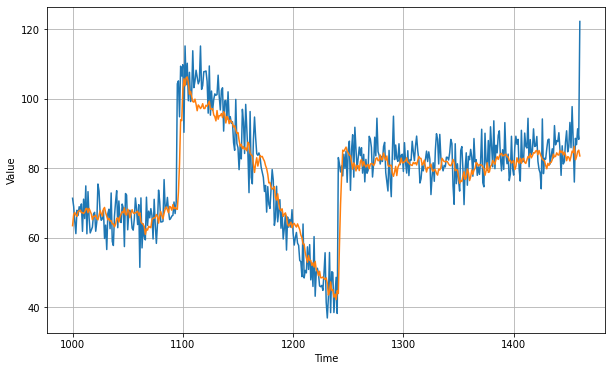

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1126122

## Fully Convolutional Forecasting

In [12]:
#WaveNet Model!

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

#Inputlayer로 (batch size, timestep, uni/multi) input shape 지정, 인풋받기
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

#dilation rate를 달리한 Conv1D 레이어 추가하기

for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

#마지막에 필터가 1개인 Conv1D 추가하기 : timestep 1개당 출력값이 1개이기 때문!
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 2s 47ms/step - loss: 42.2341 - mae: 42.7330 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 41.8293 - mae: 42.3284 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 41.4367 - mae: 41.9357 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 41.0108 - mae: 41.5098 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 40.4787 - mae: 40.9776 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 39.7341 - mae: 40.2328 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 38.5883 - mae: 39.0871 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 36.6836 - mae: 37.1822 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 33.3644 - mae: 33.8629 - lr: 1.8

(0.0001, 0.1, 0.0, 30.0)

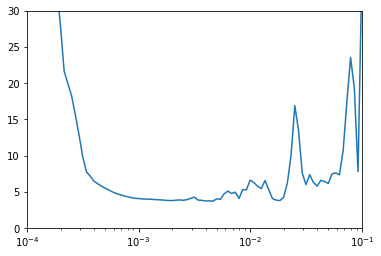

In [13]:
#RNN에 비해 learning rate가 매우 크더라도 stable함을 알 수 있음!

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
8/8 [==============================] - 3s 139ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 0s 40ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9777 - val_mae: 68.4777
Epoch 3/500
8/8 [==============================] - 0s 41ms/step - loss: 35.1357 - mae: 35.6344 - val_loss: 60.8664 - val_mae: 61.3664
Epoch 4/500
8/8 [==============================] - 1s 46ms/step - loss: 30.8280 - mae: 31.3262 - val_loss: 50.2194 - val_mae: 50.7190
Epoch 5/500
8/8 [==============================] - 1s 43ms/step - loss: 24.9595 - mae: 25.4564 - val_loss: 36.6519 - val_mae: 37.1479
Epoch 6/500
8/8 [==============================] - 1s 45ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5157
Epoch 7/500
8/8 [==============================] - 1s 43ms/step - loss: 18.8909 - mae: 19.3858 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 0s 41ms/st

In [15]:
model = keras.models.load_model("my_checkpoint.h5")

In [16]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

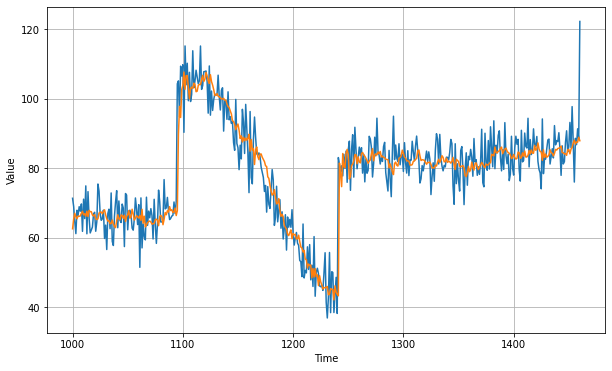

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [18]:
#현재까지 중 가장 좋은 mae

keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5306926